# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

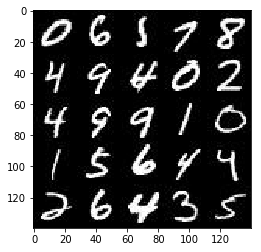

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

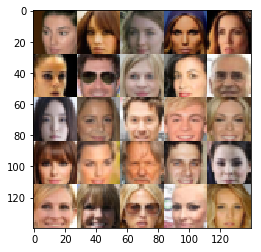

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'F

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x128
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x256
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x512
        
        #Adding dropout layer
        dropout = tf.nn.dropout(relu3, 0.8)

        # Flatten it
        flat = tf.reshape(dropout, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        #x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        #x3 = tf.layers.batch_normalization(x3, training=is_train)
        #x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
import time

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    print(data_shape)
    
    image_width = data_shape[1]
    image_height = data_shape[2]
    channels_count = data_shape[3]
    
    input_real, input_z, lr = model_inputs(image_width, image_height, channels_count, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels_count)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    show_every = 50
    print_every = 50
    
    steps = 0    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1
                time.sleep(0.02)
                
                x = batch_images.reshape((batch_size, image_width, image_height, channels_count))
                x = x*2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: x, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: x, lr: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: x, lr: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, channels_count, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
Epoch 1/2... Discriminator Loss: 0.7140... Generator Loss: 1.6872


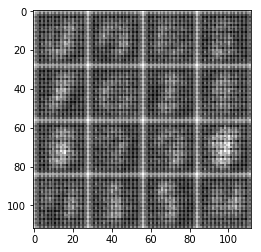

Epoch 1/2... Discriminator Loss: 1.0453... Generator Loss: 0.6574


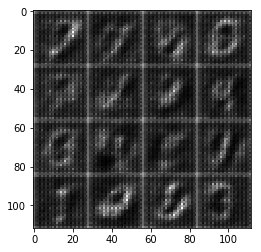

Epoch 1/2... Discriminator Loss: 0.7790... Generator Loss: 2.0675


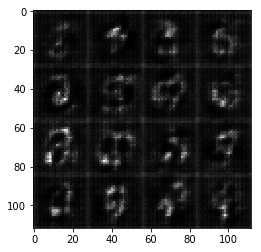

Epoch 1/2... Discriminator Loss: 0.7096... Generator Loss: 1.0216


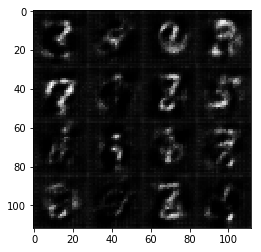

Epoch 1/2... Discriminator Loss: 0.5591... Generator Loss: 1.8865


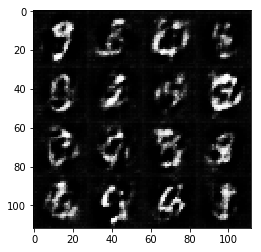

Epoch 1/2... Discriminator Loss: 0.5885... Generator Loss: 2.3675


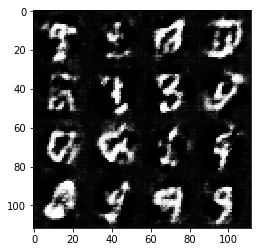

Epoch 1/2... Discriminator Loss: 0.4687... Generator Loss: 1.8910


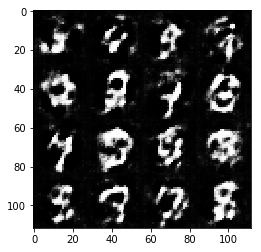

Epoch 1/2... Discriminator Loss: 0.4691... Generator Loss: 1.9984


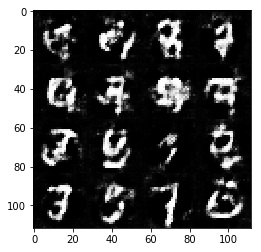

Epoch 1/2... Discriminator Loss: 0.7463... Generator Loss: 1.5340


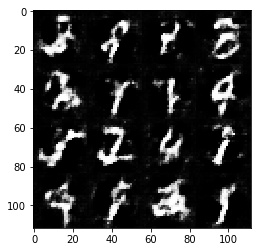

Epoch 1/2... Discriminator Loss: 0.7646... Generator Loss: 1.1883


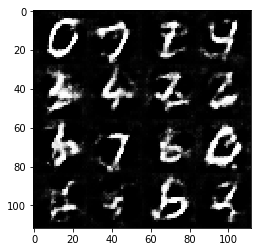

Epoch 1/2... Discriminator Loss: 0.5424... Generator Loss: 1.4065


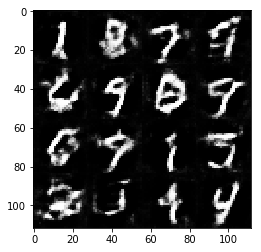

Epoch 1/2... Discriminator Loss: 0.5781... Generator Loss: 2.4374


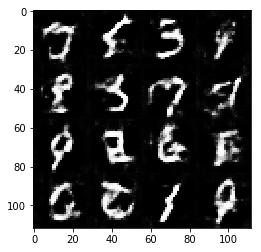

Epoch 1/2... Discriminator Loss: 2.1337... Generator Loss: 0.2173


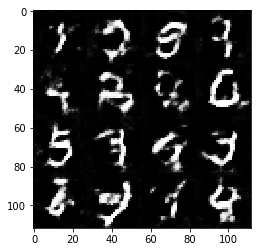

Epoch 1/2... Discriminator Loss: 0.6454... Generator Loss: 1.1242


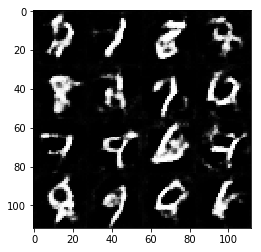

Epoch 1/2... Discriminator Loss: 1.0234... Generator Loss: 0.7357


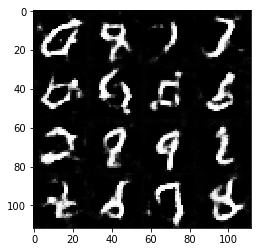

Epoch 1/2... Discriminator Loss: 1.1510... Generator Loss: 0.5846


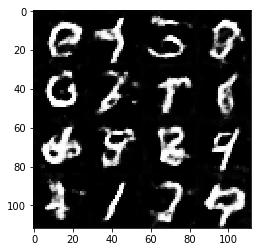

Epoch 1/2... Discriminator Loss: 0.9297... Generator Loss: 3.2592


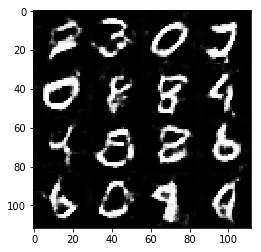

Epoch 1/2... Discriminator Loss: 0.7048... Generator Loss: 2.0144


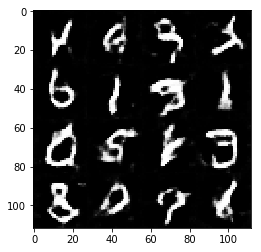

Epoch 2/2... Discriminator Loss: 0.6292... Generator Loss: 1.5156


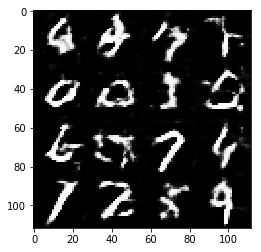

Epoch 2/2... Discriminator Loss: 0.5064... Generator Loss: 1.5139


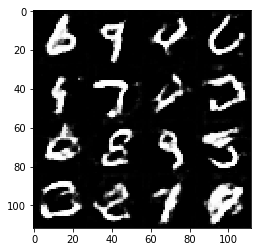

Epoch 2/2... Discriminator Loss: 0.4161... Generator Loss: 1.9229


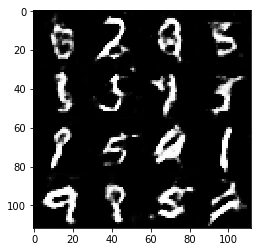

Epoch 2/2... Discriminator Loss: 0.5861... Generator Loss: 1.2530


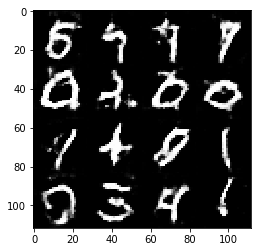

Epoch 2/2... Discriminator Loss: 0.5986... Generator Loss: 1.0316


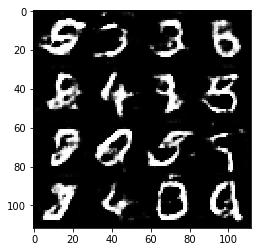

Epoch 2/2... Discriminator Loss: 1.2001... Generator Loss: 1.5633


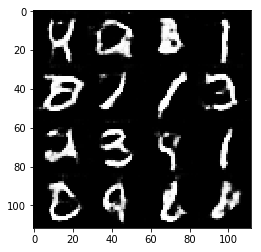

Epoch 2/2... Discriminator Loss: 0.5033... Generator Loss: 1.6491


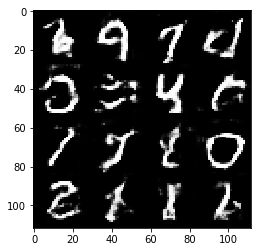

Epoch 2/2... Discriminator Loss: 0.5766... Generator Loss: 1.1237


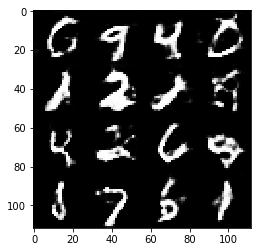

Epoch 2/2... Discriminator Loss: 0.6110... Generator Loss: 1.1802


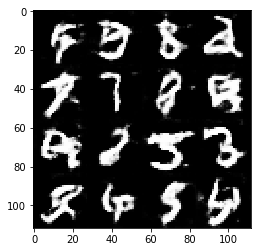

Epoch 2/2... Discriminator Loss: 0.6002... Generator Loss: 1.0739


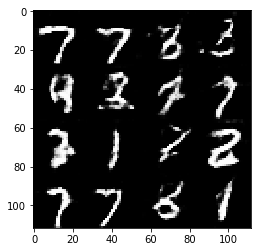

Epoch 2/2... Discriminator Loss: 0.4822... Generator Loss: 1.4991


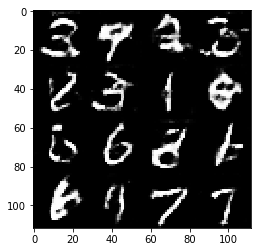

Epoch 2/2... Discriminator Loss: 1.1786... Generator Loss: 3.9481


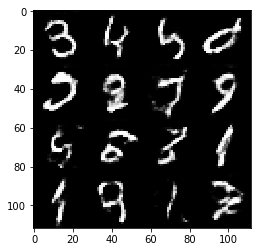

Epoch 2/2... Discriminator Loss: 0.8112... Generator Loss: 1.1220


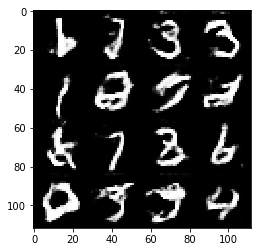

Epoch 2/2... Discriminator Loss: 0.4583... Generator Loss: 1.8224


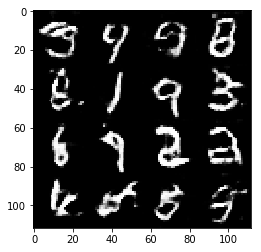

Epoch 2/2... Discriminator Loss: 0.5866... Generator Loss: 1.2698


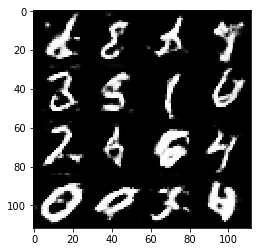

Epoch 2/2... Discriminator Loss: 1.4588... Generator Loss: 0.5383


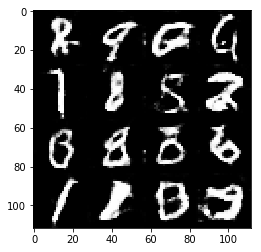

Epoch 2/2... Discriminator Loss: 0.4965... Generator Loss: 1.3667


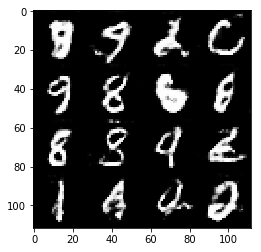

Epoch 2/2... Discriminator Loss: 0.6575... Generator Loss: 0.9295


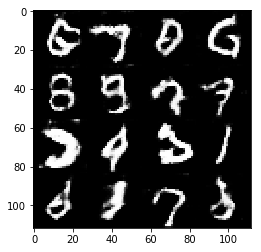

Epoch 2/2... Discriminator Loss: 0.9327... Generator Loss: 0.7300


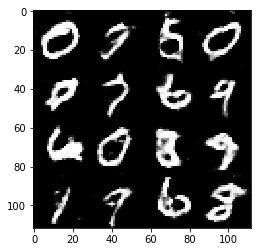

In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
Epoch 1/1... Discriminator Loss: 0.3730... Generator Loss: 31.3397


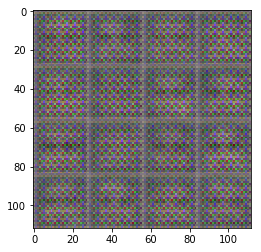

Epoch 1/1... Discriminator Loss: 1.1373... Generator Loss: 0.6572


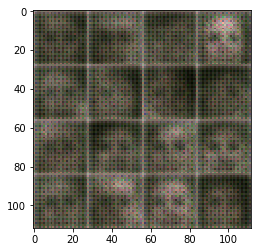

Epoch 1/1... Discriminator Loss: 1.0358... Generator Loss: 1.0339


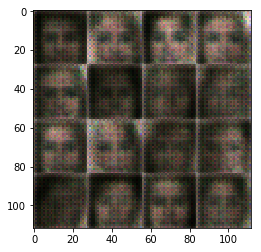

Epoch 1/1... Discriminator Loss: 0.9748... Generator Loss: 0.9367


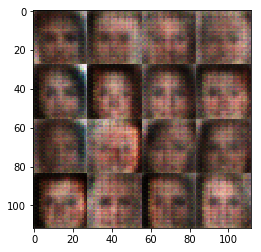

Epoch 1/1... Discriminator Loss: 0.5479... Generator Loss: 1.3235


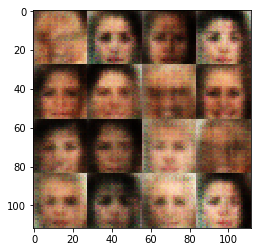

Epoch 1/1... Discriminator Loss: 0.6308... Generator Loss: 1.2150


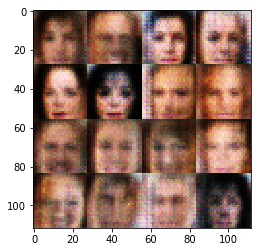

Epoch 1/1... Discriminator Loss: 2.8299... Generator Loss: 0.1587


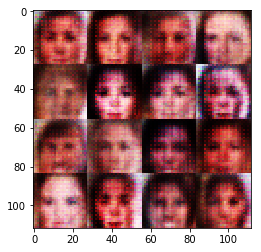

Epoch 1/1... Discriminator Loss: 0.2792... Generator Loss: 3.6432


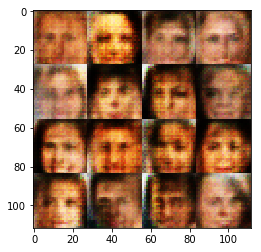

Epoch 1/1... Discriminator Loss: 0.1249... Generator Loss: 4.1812


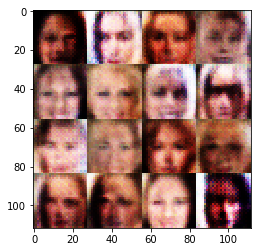

Epoch 1/1... Discriminator Loss: 0.1335... Generator Loss: 3.3596


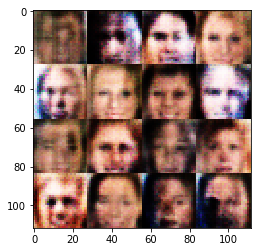

Epoch 1/1... Discriminator Loss: 0.3331... Generator Loss: 6.2232


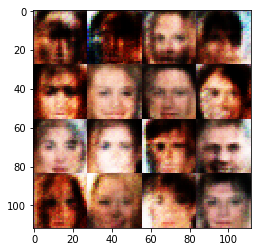

Epoch 1/1... Discriminator Loss: 0.0159... Generator Loss: 8.0740


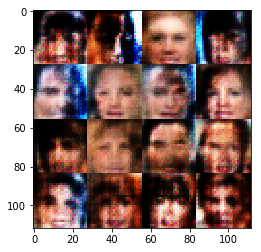

Epoch 1/1... Discriminator Loss: 0.1574... Generator Loss: 10.0730


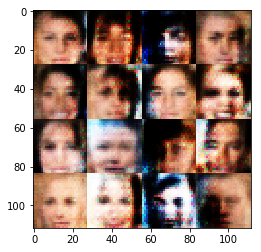

Epoch 1/1... Discriminator Loss: 0.0203... Generator Loss: 10.3953


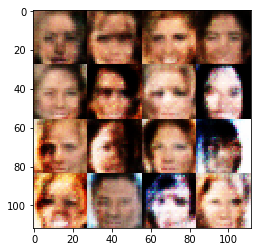

Epoch 1/1... Discriminator Loss: 0.0112... Generator Loss: 11.6321


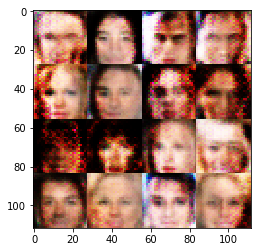

Epoch 1/1... Discriminator Loss: 0.0527... Generator Loss: 3.3586


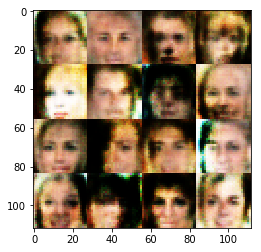

Epoch 1/1... Discriminator Loss: 0.0687... Generator Loss: 3.2885


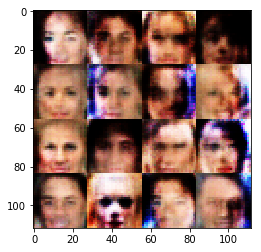

Epoch 1/1... Discriminator Loss: 0.4012... Generator Loss: 11.1198


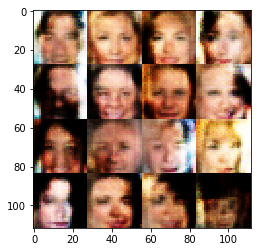

Epoch 1/1... Discriminator Loss: 0.0094... Generator Loss: 8.3873


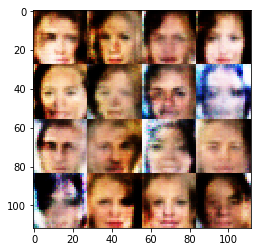

Epoch 1/1... Discriminator Loss: 0.0028... Generator Loss: 9.3237


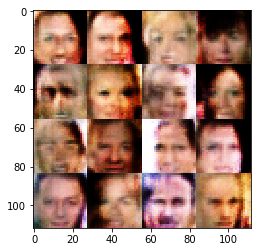

Epoch 1/1... Discriminator Loss: 0.0031... Generator Loss: 9.3780


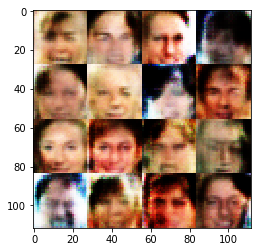

Epoch 1/1... Discriminator Loss: 0.8876... Generator Loss: 1.1803


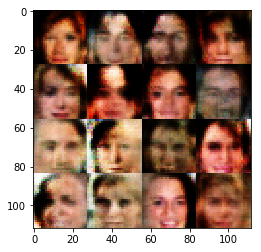

Epoch 1/1... Discriminator Loss: 0.8642... Generator Loss: 0.8416


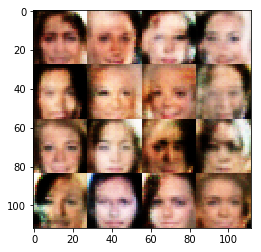

Epoch 1/1... Discriminator Loss: 0.3078... Generator Loss: 2.3637


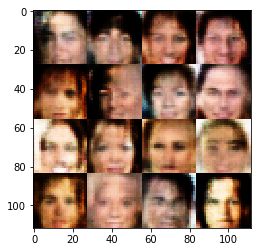

Epoch 1/1... Discriminator Loss: 0.1102... Generator Loss: 2.9340


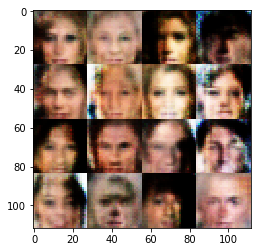

Epoch 1/1... Discriminator Loss: 0.0078... Generator Loss: 7.1092


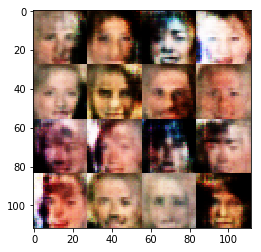

Epoch 1/1... Discriminator Loss: 0.1421... Generator Loss: 10.4795


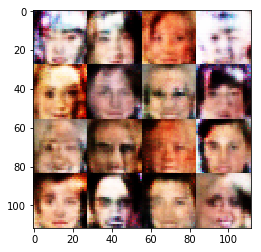

Epoch 1/1... Discriminator Loss: 0.0052... Generator Loss: 7.3945


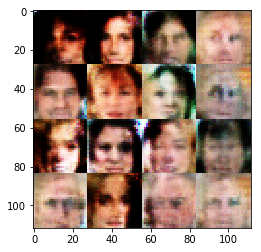

Epoch 1/1... Discriminator Loss: 0.0044... Generator Loss: 7.9174


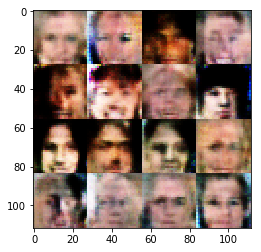

Epoch 1/1... Discriminator Loss: 0.6974... Generator Loss: 1.0447


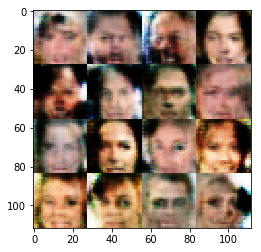

Epoch 1/1... Discriminator Loss: 0.0319... Generator Loss: 5.3704


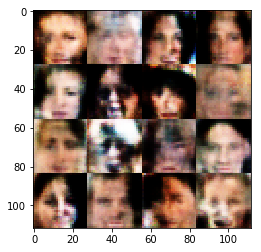

Epoch 1/1... Discriminator Loss: 0.0232... Generator Loss: 11.0538


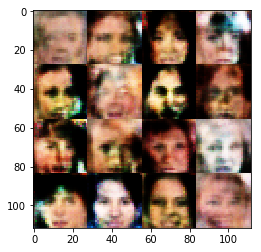

Epoch 1/1... Discriminator Loss: 0.7619... Generator Loss: 0.9970


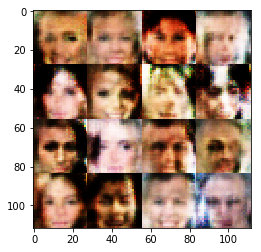

Epoch 1/1... Discriminator Loss: 0.0989... Generator Loss: 3.3209


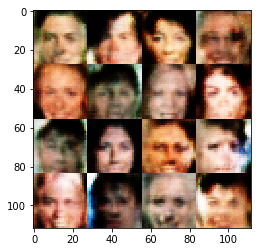

Epoch 1/1... Discriminator Loss: 0.9635... Generator Loss: 0.7369


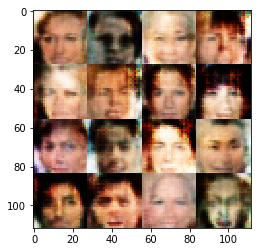

Epoch 1/1... Discriminator Loss: 0.0097... Generator Loss: 6.3468


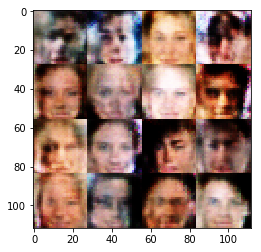

Epoch 1/1... Discriminator Loss: 0.1363... Generator Loss: 2.9407


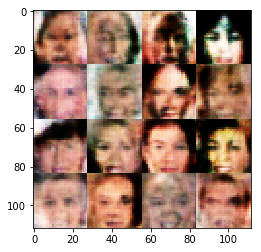

Epoch 1/1... Discriminator Loss: 0.0237... Generator Loss: 9.9780


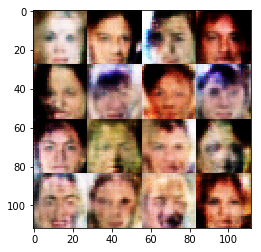

Epoch 1/1... Discriminator Loss: 0.3259... Generator Loss: 1.7639


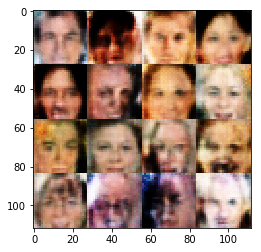

Epoch 1/1... Discriminator Loss: 0.0156... Generator Loss: 6.5141


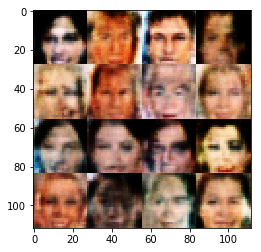

Epoch 1/1... Discriminator Loss: 0.2168... Generator Loss: 2.4132


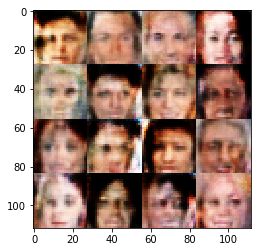

Epoch 1/1... Discriminator Loss: 0.0156... Generator Loss: 5.8271


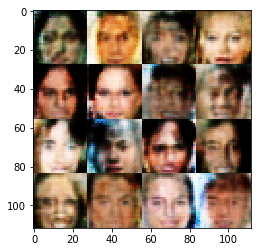

Epoch 1/1... Discriminator Loss: 0.0161... Generator Loss: 8.9872


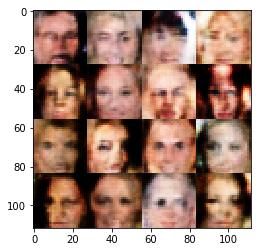

Epoch 1/1... Discriminator Loss: 0.0292... Generator Loss: 8.1390


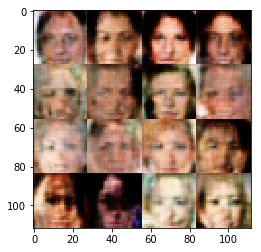

Epoch 1/1... Discriminator Loss: 0.0278... Generator Loss: 4.8784


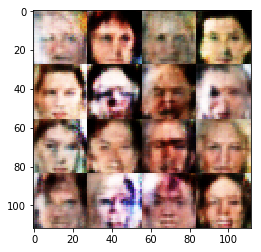

Epoch 1/1... Discriminator Loss: 0.4314... Generator Loss: 2.2756


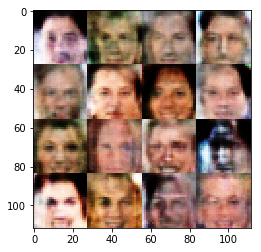

Epoch 1/1... Discriminator Loss: 0.7036... Generator Loss: 3.0193


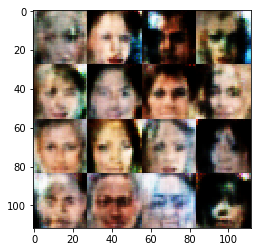

Epoch 1/1... Discriminator Loss: 0.0129... Generator Loss: 9.5438


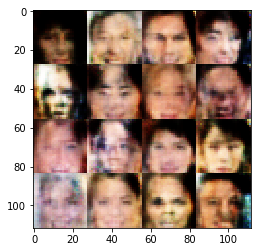

Epoch 1/1... Discriminator Loss: 0.0046... Generator Loss: 7.1816


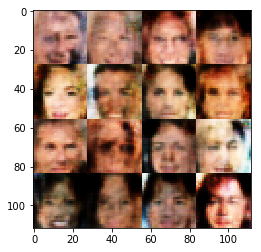

Epoch 1/1... Discriminator Loss: 0.0492... Generator Loss: 3.5652


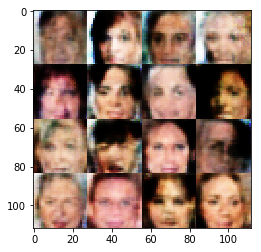

Epoch 1/1... Discriminator Loss: 0.2541... Generator Loss: 3.3362


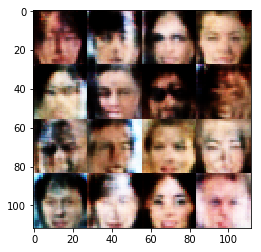

Epoch 1/1... Discriminator Loss: 0.0170... Generator Loss: 7.0915


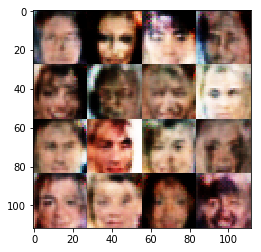

Epoch 1/1... Discriminator Loss: 0.0805... Generator Loss: 3.1618


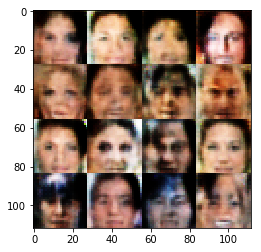

Epoch 1/1... Discriminator Loss: 0.4611... Generator Loss: 1.6884


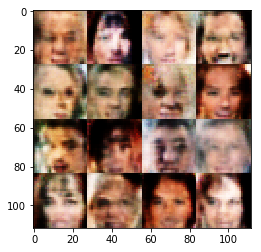

Epoch 1/1... Discriminator Loss: 0.3106... Generator Loss: 5.8645


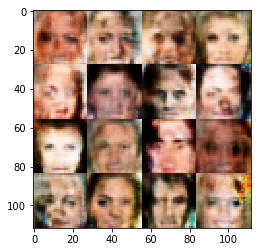

Epoch 1/1... Discriminator Loss: 0.4349... Generator Loss: 1.4944


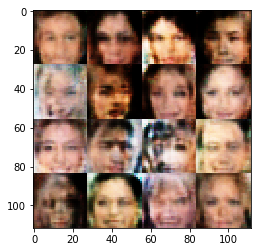

Epoch 1/1... Discriminator Loss: 0.3727... Generator Loss: 1.6332


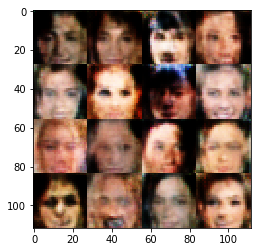

Epoch 1/1... Discriminator Loss: 0.4887... Generator Loss: 5.7057


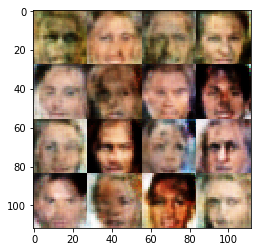

Epoch 1/1... Discriminator Loss: 0.6602... Generator Loss: 2.3296


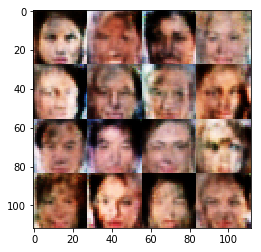

Epoch 1/1... Discriminator Loss: 1.6994... Generator Loss: 0.3016


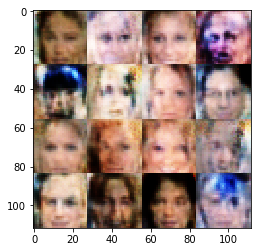

Epoch 1/1... Discriminator Loss: 0.0248... Generator Loss: 4.5343


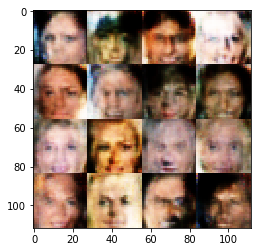

Epoch 1/1... Discriminator Loss: 0.2873... Generator Loss: 7.8541


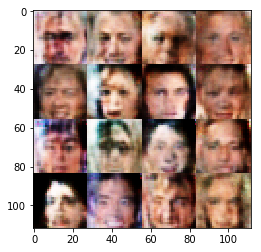

Epoch 1/1... Discriminator Loss: 0.0596... Generator Loss: 4.0351


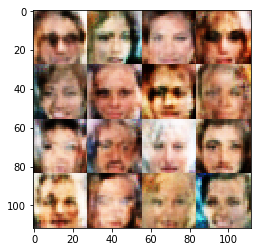

In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.